# Miniproject 3: Landing on the Moon

## Introduction

In this notebook, I will teach an agent to play the Lunar Lander game from OpenAI Gym. In this game, the agent needs to learn how to land a lunar module safely on the surface of the moon. 

The state space is 8-dimensional and (mostly) continuous, consisting of the **X and Y coordinates, the X and Y velocity, the angle, and the angular velocity of the lander, and two booleans indicating whether the left and right leg of the lander have landed on the moon.**

The agent gets a reward of **+100 for landing safely** and **-100 for crashing**. In addition, it receives "shaping" rewards at every step. It receives positive rewards for moving closer to [0,0], decreasing in velocity, shifting to an upright angle and touching the lander legs on the moon. It receives negative rewards for moving away from the landing site, increasing in velocity, turning sideways, taking the lander legs off the moon and for using fuel (firing the thrusters). The **best score** an agent can achieve in an episode is about **+250**.

We consider, here, the discrete version of this task in which the agent can take one of four actions at each time step: **[do nothing, fire engines left, fire engines right, fire engines down]**. 

We will use **Policy Gradient** approaches (using the REINFORCE rule) to learn the task. In Policy Gradient methods, the network generates a probability distribution over actions, and is trained to maximize expected future rewards given an observation in opposition to maximizing the probability of a specific target output given an observation as input. 

## Setup

We load the required packages.

### Gym Setup

We load the Reinforcement Learning environments from Gym and limit each episode to 500 steps in order to train faster. 

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import logging
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
from gym.envs.box2d.lunar_lander import heuristic

import tensorflow as tf
from tensorflow.contrib.distributions import Beta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


from utils import *

seed = 42
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed*2)

W0809 18:12:24.948072  4548 deprecation_wrapper.py:119] From C:\EPFL\Blog\OpenAI\utils.py:19: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



In [2]:
gym.logger.setLevel(logging.ERROR)
discrete_env = gym.make('LunarLander-v2')
discrete_env._max_episode_steps = 500
discrete_env.seed(seed*3)
gym.logger.setLevel(logging.WARN)

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams["animation.html"] = "jshtml"

## Test runs

To have better idea of how the environment works, we run two tests :
- one is a plot of an episode resulting from random actions at each point in time
- another is a "perfect" episode thanks to a build-in function to land safely within the yellow flags. 


In [3]:
def run_fixed_episode(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        action = policy(env, observation)
        observation, reward, done, info = env.step(action)
    return frames
    
def random_policy(env, observation):
    return env.action_space.sample()

def heuristic_policy(env, observation):
    return heuristic(env.unwrapped, observation)

**Random actions**

In [4]:
random_episode = run_fixed_episode(discrete_env, random_policy)
render(random_episode, discrete_env, "random_episode")

**Perfect episode**

In [5]:
perfect_episode = run_fixed_episode(discrete_env, heuristic_policy)
render(perfect_episode, discrete_env, "perfect_episode")

## The Agent

We create a python class that will represent the reinforcement learning agent (along with its decision-making network).

**Network Architecture :**
- The network takes the 8-dimensional state space as input and output a softmax distribution over the 4 discrete actions. 
- It has 3 hidden layers with 16 units each using ReLU activations.
- We use the REINFORCE loss function : we use the categorical cross-entropy but multiply each observation’s loss by the associated discounted reward. See : sample weights in train function
-  The "simple_baseline" keyword implement a baseline based on a moving average of the returns.
- The"_build_network" function of RLAgent creates a second **"value network"** when "adaptive" is passed for the baseline argument. The value should has the same structure as the policy network, without the softmax at the output.  Furthermore, the value network is trained on the Mean-Squared Error compared to the adjusted returns.

**Notes on regularization :**

-> $exploration-exploitation$ $dilemma$ :  To maximize rewards, the agent needs to "exploit", or take the actions that it thinks will lead to the highest reward. However, doing this too early in training can result in a poor policy; the agent needs to adequately "explore" the state space in order to learn which policy is actually best at each state.

In Q-learning, this is often accomplished by having the agent take random actions with a certain probability early in training. In Policy Gradient, this randomness is built-in because the agent is sampling from a policy distribution. 

We may try to improve exploration by making sure that the probability doesn't become too concentrated on certain actions early in training. In other words, we should try to regularize the information entropy (or uncertainty) of the policy distribution.

Furthermore, Entropy regularization is related to but distinct from Maximum Entropy Reinforcement Learning (MERL). In the MERL framework the objective function is modified so that the agent tries to maximize reward and entropy of the policy along the full trajectory.

$Actions$ $taken:$
- We include a regularizer on the output of the policy network based on the entropy of the categorical distribution. It is done by implemeting the $EntropyActivityRegulatizer$ class which compute the entropy of the policy weighted by self.entropy_cost and passing it to your output layer with the activity_regularizer keyword.
-  We add entropy to reward when computing the episode returns. This is done by subtracting the log of the probability of the action taken at that time step (weighted by self.max_ent_cost) from the reward at that step.

In [16]:
class EntropyActivityRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, y, entropy_cost):
        self.y = y
        self.entropy_cost = entropy_cost
    
    def __call__(self, x):
        y_hat = K.mean(x, axis=0)
        return self.entropy_cost * K.sum(K.categorical_crossentropy(to_categorical(self.y, 4), y_hat))

    def get_config(self):
        return {"name": self._class.name_}

In [17]:
class RLAgent(object):
    
    def __init__(self, n_obs, action_space, policy_learning_rate, value_learning_rate, 
                 discount, baseline = None, entropy_cost = 0, max_ent_cost = 0):

        #state and action dimensions
        self.n_obs = n_obs  
        self.n_act = action_space.n
        
        #discount on rewards
        self.gamma = discount
        
        #learning rates
        self.policy_learning_rate = policy_learning_rate
        self.value_learning_rate = value_learning_rate
        
        #Optional : type of baseline to choose
        self.use_baseline = baseline
        
        #costs
        self.entropy_cost = entropy_cost
        self.max_ent_cost = max_ent_cost

        #These lists stores the cumulative observations for the current episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []

        #Build the networks
        self.policy_model, self.value_model = self._build_network()
        
        #Keep track of each chosen action probability
        self.taken_action_probability = 0

    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above. """        
        self.episode_observations.append(state)
        self.episode_actions.append(to_categorical(action, 4))
        self.episode_rewards.append(reward)
        
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        
        state = state.reshape([1, state.shape[0]])
        prediction = self.policy_model.predict(state)
        distribution = prediction / np.sum(prediction)
        action = np.random.choice(self.n_act, p=distribution[0])
        
        if (self.max_ent_cost != 0):
            self.taken_action_probability = distribution[0][action]
        return action

    def train(self):
        """ When this function is called, the accumulated observations, actions and discounted rewards from the
            current episode are fed into the network and used for training."""
        
        if (self.use_baseline == 'adaptive'):
            rewards = self._get_returns()
            x = np.vstack(self.episode_observations)
            y = np.vstack(self.episode_actions)
            
            advantages = np.zeros((x.shape[0], self.n_act))
            values = self.value_model.predict(x)
            
            for i in range(len(advantages)):
                idx = 0
                for k in range(len(y[i])):
                    if (y[i, k] == 1):
                        idx = k
                advantages[i][idx] = rewards[i] - values[i][0]
            
            self.policy_model.fit(x, advantages)
            self.value_model.fit(x, rewards)
            
        else :
            rewards = self._get_returns()
            x = np.vstack(self.episode_observations)
            y = np.vstack(self.episode_actions)

            weights = list(rewards.reshape([1, rewards.shape[0]]))
            self.policy_model.fit(x, y, sample_weight=weights)
            
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []
        
    def _get_returns(self):
        """ This function process self.episode_rewards and return the discounted episode returns
            at each step in the episode, then optionally apply a baseline."""
        
        discounted_episode_rewards = np.zeros_like(self.episode_rewards)
        reward_step = 0
        for r in reversed(range(len(self.episode_rewards))):
            reward_step = reward_step * self.gamma + self.episode_rewards[r]
            if (self.max_ent_cost != 0):
                reward_step = reward_step - self.max_ent_cost * np.log(self.taken_action_probability)
            discounted_episode_rewards[r] = reward_step

        if (self.use_baseline == 'simple'):
            smoothed_rewards = [np.mean(discounted_episode_rewards[max(0,i-1):i+1]) 
                                for i in range(len(discounted_episode_rewards))]
            discounted_episode_rewards = smoothed_rewards

        return discounted_episode_rewards - np.mean(discounted_episode_rewards)                                        
                                                    
    def _build_network(self):
        """ This function build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""
        
        #Initialize the two networks
        policy_model = None
        value_model = None
        
        policy_model = Sequential()
        policy_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', input_dim=self.n_obs))
        policy_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        policy_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
            
        if (self.entropy_cost != 0):
            regularizer = EntropyActivityRegularizer(self.episode_actions, self.entropy_cost)
            policy_model.add(Dense(self.n_act, activation='softmax', activity_regularizer=regularizer))
        else :
            policy_model.add(Dense(self.n_act, activation='softmax'))

        policy_model.compile(loss='categorical_crossentropy', 
                             optimizer=Adam(lr=self.policy_learning_rate), 
                             metrics=['categorical_accuracy'])
        
        if (self.use_baseline == 'adaptive'):
            value_model = Sequential()            
            value_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', input_dim=self.n_obs))
            value_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
            value_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform')) 
            value_model.add(Dense(1))
            
            value_model.compile(loss='mse', 
                                optimizer=Adam(lr=self.value_learning_rate))
        
        return policy_model, value_model

Multiples values can be tried during fine-tuning, we choose some at random here, just for demonstration purposes.
For the interested reader, here are some values to try:

- value_learning_rate = [0.001, 0.01, 0.1]
- policy_learning_rate = [0.001, 0.01, 0.1]
- entropy_costs = [0.001, 0.01, 0.1]
- max_ent_costs = [0.001, 0.01, 0.1]



## Running the Experiments

In [21]:
num_episodes = 2000

def run_experiment(experiment_name, env, num_episodes, policy_learning_rate = 0.001, value_learning_rate = 0.001, 
                   baseline=None, entropy_cost = 0, max_ent_cost = 0):
    """ This method is used to setup an experiment. We will operates on an Observe-Decide-Act cycle."""     


    #Initiate the learning agent
    agent = RLAgent(n_obs = env.observation_space.shape[0], action_space = env.action_space,
                    policy_learning_rate = policy_learning_rate, value_learning_rate = value_learning_rate, 
                    discount=0.99, baseline = baseline, entropy_cost = entropy_cost, max_ent_cost = max_ent_cost)

    rewards = []
    all_episode_frames = []
    step = 0
    for episode in range(1, num_episodes+1):
    
        #Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(10)
        if episode % 500 == 0:
            episode_frames = []
            
        #Reset the environment to a new episode
        observation = env.reset()
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.render(mode='rgb_array'))

            # 1. Decide on an action based on the observations
            action = agent.decide(observation)

            # 2. Take action in the environment
            next_observation, reward, done, info = env.step(action)
            episode_reward += reward

            # 3. Store the information returned from the environment for training
            agent.observe(observation, action, reward)

            # 4. When we reach a terminal state ("done"), use the observed episode to train the network
            if done:
                rewards.append(episode_reward)
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)
                agent.train()
                break

            # Reset for next step
            observation = next_observation
            step += 1
            
    return all_episode_frames, agent

In [24]:
policy_learning_rate = 0.001
value_learning_rate = 0.01
entropy_cost = 0.1
max_ent_cost = 0.01

**Results**

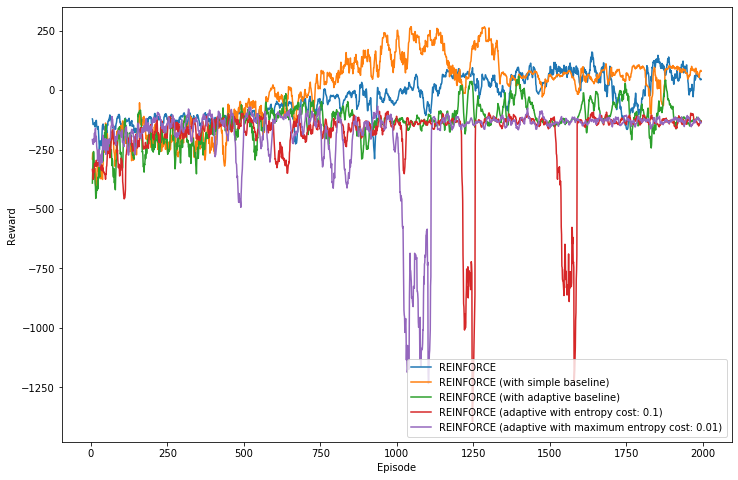

74/74 [==============================] - 0s 81us/sample - loss: 20.7185


In [25]:
results = Results()

#No baseline
episodes, agent_basic = run_experiment("REINFORCE", discrete_env, num_episodes, policy_learning_rate)

# Using simple baseline
episodes_simple_baseline, agent_simple = run_experiment("REINFORCE (with simple baseline)",\
                                                        discrete_env, num_episodes, policy_learning_rate, baseline='simple')

#Using adaptive baseline with value network
episodes_adaptive_baseline, agent_adaptive = run_experiment("REINFORCE (with adaptive baseline)",\
                                                            discrete_env, num_episodes, policy_learning_rate,\
                                                            value_learning_rate, baseline='adaptive')

#Using adaptive baseline with value network and entropy cost
episodes_adaptive_entropy_cost, agent_adaptive_entropy_cost = run_experiment("REINFORCE (adaptive with entropy cost: 0.1)" ,\
                                                                             discrete_env, num_episodes, policy_learning_rate,\
                                                                             value_learning_rate, baseline='adaptive',\
                                                                             entropy_cost=entropy_cost)


#Using adaptive baseline with value network and max entropy cost
episodes_adaptive_max_entropy_cost, agent_adaptive_max_entropy_cost = run_experiment("REINFORCE (adaptive with maximum entropy cost: 0.01)", discrete_env, num_episodes, policy_learning_rate, value_learning_rate, 
                          baseline='adaptive', max_ent_cost=max_ent_cost)

## Let's play with the different models

**No baseline**

In [26]:
render(episodes[-1], discrete_env, "no_baseline")

**Using simple baseline**

In [27]:
render(episodes_simple_baseline[-1], discrete_env, "simple_baseline")

**Using adaptive baseline with value network**

In [28]:
render(episodes_adaptive_baseline[-1], discrete_env, "adaptive_baseline")

**Using adaptive baseline with value network and entropy cost**

In [29]:
render(episodes_adaptive_entropy_cost[-1], discrete_env, "adaptive_entropy")

**Using adaptive baseline with value network and max entropy cost**

In [30]:
render(episodes_adaptive_max_entropy_cost[-1], discrete_env, "adaptive_max_entropy")